In [2]:
import os
import sys
import math
from liblibra_core import * 
from libra_py import *
import numpy as np
import cProfile, pstats, io
import matplotlib.pyplot as plt
from scipy.special import gamma
from NumpyMIW import * #Calls below
import py3Dmol

#### Explicit function calls from NumpyMIW:
- MIW_Forces(X, params) : Used to compute MIW forces
- Write_Frame_To_XYZ(X, 1, filename) : Used in dyanmics for writing out trajectory to .xyz file.
- Populate1DUniform( number of worlds, spacing between the worlds)


### Set up the functions to compute potential/forces for a partcle in an D-dimensional harmonic potential.

$X =  [ [x_{00}, x_{01}, ...,  x_{0D}], [x_{10}, x_{11}, ...,  x_{1D}], ..., [x_{N0}, x_{N1}, ..., x_{ND}]]$

In [5]:
def Harmonic_Potential(X, xo, K):
    res = 0 
    for i in range(len(X)):
        for k in range(len(X[0])):
            res +=  .5 * K * (X[i][k] - xo)**2
    return(res)

# These two functions just compute harmonic potential/forces for something centered at xo along all DOFs
def Harmonic_Forces(X, xo, K):
    F = np.zeros(X.shape)
    for i in range(len(X)):
        for k in range(len(X[0])):
            F[i][k] = - K * ( X[i][k] - xo ) 
    return(F)

# Uses verlet for updates with both MIW and MM forces.
def VerletDynamics(X, V, params, method = 0, filename = 0):
    dt = params["dt"]
    steps = params["steps"]
    D = params["D"]
    b = params["b"]
    ktype = params["ktype"]
    UCorrGauss = D/(4.0 * M[0][0] * b**2) 
    UCorrExp = D/(8.0 * M[0][0] * b**2) 
    
    #  MIW + Harmonic
    if method == 0:
        # Want to store the energies for steps+1 configurations of the system.
        MIW_Energy = np.zeros( steps+1 )
        Kinetic_Energy = np.zeros( MIW_Energy.shape )
        Harmonic_Energy = np.zeros( MIW_Energy.shape )
        Total_Energy = np.zeros( MIW_Energy.shape )
        
        K = params["K"]
        xo = params["xo"]
        
        # Compute initial MIW potential & forces
        F, U = MIW_Forces(X, params)
        
        #Correction assumes all DoFs correspond to same mass for now
        if ktype.lower() == "gaussian":
            U += UCorrGauss
        elif ktype.lower() == "exponential":
            U += UCorrExp
        
        # Compute initial harmonic potential & forces
        F += Harmonic_Forces(X, xo, K)
        Uharm = Harmonic_Potential(X, xo, K)
        
        # Compute initial kinetic energy
        # Currently hardcoded for all dof's with same mass.
        res = 0
        for i in range(len(V)):
            for j in range(len(V[0])):
                res += .5 * M[i][j] * (V[i][j] ** 2)
        
        
        # Update the lists with the energies before the first step
        MIW_Energy[0] = U
        Kinetic_Energy[0] = res
        Harmonic_Energy[0] = (Uharm)
        Total_Energy[0] =  U + res + Uharm 
        
        for i in range(steps):
            #Velocity verlet update
            V = V + .5 * np.divide(F, M) * dt
            X = X + V * dt
            
            # Compute new forces for the 2nd part of the velocity update
            F, U = MIW_Forces(X, params)
            if ktype.lower() == "gaussian":
                U += UCorrGauss 
            elif ktype.lower() == "exponential":
                U += UCorrExp
            F += Harmonic_Forces(X, xo, K)
            Uharm = Harmonic_Potential(X, xo, K)
            
            # 2nd part of the velocity update
            V = V + .5 * np.divide(F, M) * dt
            
            res = 0
            for idx1 in range(len(V)):
                for idx2 in range(len(V[0])):
                    res += .5 * M[idx1][idx2] * (V[idx1][idx2] ** 2)
            
            # Update the lists with the respective energies
            # 
            MIW_Energy[i+1] = U
            Kinetic_Energy[i+1] = res
            Harmonic_Energy[i+1] = (Uharm)
            Total_Energy[i+1] =   res + Uharm + U
            
            if type(filename) != int:
                Write_Frame_To_XYZ(X, 1, filename)
                
        return(MIW_Energy, Harmonic_Energy, Kinetic_Energy,  Total_Energy)
    
    # Harmonic Only
    elif method == 1:
        Kinetic_Energy = np.zeros( steps+1 )
        Harmonic_Energy = np.zeros( Kinetic_Energy.shape )
        Total_Energy = np.zeros( Kinetic_Energy.shape )
        K = params["K"]
        xo = params["xo"]
        
        # Compute initial harmonic potential & forces
        F = Harmonic_Forces(X, xo, K)
        Uharm = Harmonic_Potential(X, xo, K)
        
        # Compute initial kinetic energy
        # Currently hardcoded for all dof's with same mass.
        res = 0
        for i in range(len(V)):
            for j in range(len(V[0])):
                res += .5 * M[i][j] * (V[i][j] ** 2)
        
        
        # Update the lists with the energies before the first step
        Kinetic_Energy[0] = res
        Harmonic_Energy[0] = (Uharm)
        Total_Energy[0] = res + Uharm 
        
        for i in range(steps):
            #Velocity verlet update
            V = V + .5 * np.divide(F, M) * dt
            X = X + V * dt
              
            F = Harmonic_Forces(X, xo, K)
            Uharm = Harmonic_Potential(X, xo, K)
            print("Type of res", type(Uharm))
            
            V = V + .5 * np.divide(F, M) * dt
            
            res = 0
            for idx1 in range(len(V)):
                for idx2 in range(len(V[0])):
                    res += .5 * M[idx1][idx2] * (V[idx1][idx2] ** 2)
            
            # Update the lists with the respective energies
            Kinetic_Energy[i+1] = res
            Harmonic_Energy[i+1] = (Uharm)
            Total_Energy[i+1] =   res + Uharm
            
            if type(filename) != int:
                Write_Frame_To_XYZ(X, 1, filename)
                
        return(Harmonic_Energy, Kinetic_Energy, Total_Energy)

    #  MIW
    if method == 2:
        # Want to store the energies for steps+1 configurations of the system.
        MIW_Energy = np.zeros( steps+1 )
        Kinetic_Energy = np.zeros( MIW_Energy.shape )
        Total_Energy = np.zeros ( MIW_Energy.shape )
        
        # Compute initial MIW potential & forces
        F, U = MIW_Forces(X, params)
        
        #Correction assumes all DoFs correspond to same mass for now
        if ktype.lower() == "gaussian":
            U += UCorrGauss
        elif ktype.lower() == "exponential":
            U += UCorrExp
        
        # Compute initial kinetic energy
        # Currently hardcoded for all dof's with same mass.
        res = 0
        for i in range(len(V)):
            for j in range(len(V[0])):
                res += .5 * M[i][j] * (V[i][j] ** 2)
        
        
        # Update the lists with the energies before the first step
        MIW_Energy[0] = U
        Kinetic_Energy[0] = res
        Total_Energy[0] =  U + res 
        
        for i in range(steps):
            #Velocity verlet update
            V = V + .5 * np.divide(F, M) * dt
            X = X + V * dt
            
            
            # Compute new forces for the 2nd part of the velocity update
            F, U = MIW_Forces(X, params)
            if ktype.lower() == "gaussian":
                U += UCorrGauss
            elif ktype.lower() == "exponential":
                U += UCorrExp
            
            V = V + .5 * np.divide(F, M) * dt
            
            res = 0
            for idx1 in range(len(V)):
                for idx2 in range(len(V[0])):
                    res += .5 * M[idx1][idx2] * (V[idx1][idx2] ** 2)
            
            # Update the lists with the respective energies
            # 
            MIW_Energy[i+1] = U
            Kinetic_Energy[i+1] = res
            Total_Energy[i+1] =   res + U
            
            if type(filename) != int:
                Write_Frame_To_XYZ(X, 1, filename)
                
        return(MIW_Energy, Kinetic_Energy,  Total_Energy)
                
# Very slow minimization algorithm, which is basically just the same as above with velocity reset to 0 each step.
# Swapping over to scipy optimization currently.
def MDMin(X, V, params, method = 0, filename = 0, conv_thr=1e-5):
    dt = params["dt"]
    steps = params["steps"]
    Flist = []
    if method == 0:
        K = params["K"]
        xo = params["xo"]

        F, U = MIW_Forces(X, params)
        F += Harmonic_Forces(X, xo, K)
        
        for i in range(steps):            
            X = X + .5 * np.divide(F, 1) * dt * dt
            F, U = MIW_Forces(X, params)            
            F += Harmonic_Forces(X, xo, K)
            Flist.append(max(abs(F[0])))

            if type(filename) != int:
                Write_Frame_To_XYZ(X, 1, filename)
                
            if max(abs(F[0])) < conv_thr or i == list(range(steps))[-1]:
                if max(abs(F[0])) < conv_thr:
                    print("Force convergence reached, max force component < %f" % conv_thr)
                elif i == list(range(steps))[-1]:
                    print("Maximum number of steps reached, max force component not lower than %f" % conv_thr)
                finalPotential = U
                finalPotential += Harmonic_Potential(X, xo, K)
                
                return(Flist, finalPotential)
                
    return(Flist, finalPotential)

### Relevant Constants
$0.0367493 Ha = 1 eV$

$1.88973 Bohr = 1 A$

$1 eV/A = 0.0367493/1.88973 Ha/Bohr = 0.019446852195816332 Ha/Bohr$



#### Below sets up a 1D system of N worlds
- The system is then minimized (with a slow procedure which I'll swap to use a scipy opt algorithm)
- The max force at each iteration, and the final potential are the output.
- The next codeblock below plots the forces to get an idea of how long before all force components are ~1e-4/1e-5.

In [51]:
N = 10
spacing = .3
b = .5
D = 1
X = Populate1DUniform(N, spacing)

V = np.zeros(X.shape)

M = np.zeros(X.shape)
m_p = 1836.0 # Mass of proton in au
M += m_p

eV_A2HaBohr = 0.019446852195816332

K1 = 1*eV_A2HaBohr

steps = 5000

params = {
    "J":1,
    "D":D,
    "b":b,
    "ktype":"exponential",
    "M":M,
    "K":K1,
    "xo":0,
    "dt":.1,
    "steps":steps
}

# file = "MDMin.xyz"
# os.system("rm %s" % file)
Flist, potential = MDMin(X, V, params)


Maximum number of steps reached, max force component not lower than 0.000010



# Equations being used to compare MIW ground state energy to HO Ground state energy.

----

## MIW:

$E_{tot} = U_{MW}(X) + U^{kernel}_{corr} + \Sigma_{worlds} \ V_{classical}$ Eq 15 Sturniolo
---------------------

----

## GS H.O.:

$E_o = \frac{1}{2}\hbar \omega$ with $\omega = \sqrt{\frac{k}{m}}$

Taking K = 1eV/A = $0.0194...$ Ha/Bohr

m for a Hydrogen ~ 1836 in a.u., we should have:

$\omega = \sqrt{\frac{k}{m}} = \sqrt{\frac{0.019446852195816332}{1836}} = 0.0032545302928249434$

So the ground state energy for a single HO in a.u. should be the factor below:

$E_o = .0016272651464124717 * N$ 
-----

----

## Error formulation

### From Fig 2 in Sturniolo, error is given as:


log$_{10}((E_{tot}-E_o)/(E_o))$
----

$E_{tot} \to$ MIW Energy

$E_o \to$ H.O. Energy. This is multiplied by N because MIW Energy grows with number of worlds.

----

### $U_{corr}$

The correction (Eq 14 Sturniolo) is 
$U_{corr}^{exp} = \frac{\hbar^2}{8m} \frac{D}{b^2}$, which I believe is per world, hence the factor of N where the correction is added in line 12 below.

I am not totally sure if the factor of N should be there, however I've tried both currently, and there is a larger source of error compared with the paper elsewhere, as this has little effect.


### Directly below takes the forces computed above, and plots max force vs iteration to get a feel for how many iterations are needed.
- I would add more things like average force for convergence, or change in MIW potential, but I am going to just switch to a better optimizer altogether.

Final force 0.008251516188117002
Potential after U_corr 0.33565823346354473
Log error = 1.2928569843201103
Potential 0.335658     |     Eo 0.016273


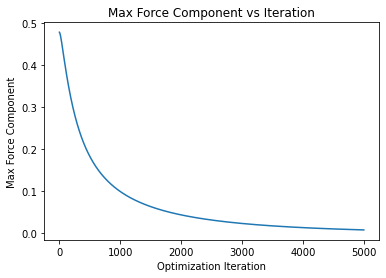

In [114]:
plt.figure(1)
plt.title("Max Force Component vs Iteration")
plt.ylabel("Max Force Component")
plt.xlabel("Optimization Iteration")
plt.plot(np.arange(len(Flist)), Flist)

Eo = .0016272651464124717

print("Final force", Flist[-1])


potential += ((N*D)/(8*M[0][0] * b**2 ))
print("Potential after U_corr", potential)

print("Log error =", np.log10( abs( potential - (Eo*N) )  / (Eo*N) ) )

print("Potential %f     |     Eo %f" % (potential, Eo*N) )

## Relative strength of MIW/Harmonic potentials

- This is just to give a rough idea in the N=2 case of at what scales the respective forces are most relevant.
- I was mainly using this to try some different values for k.

0.0
[[-2.]
 [ 2.]]


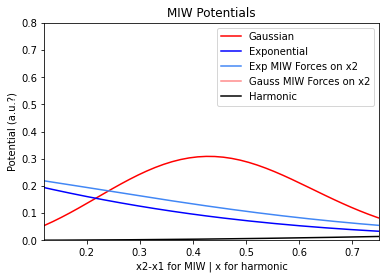

In [15]:
x1 = 0
start = 4
steps = 500
x2 = np.linspace(-start, start, steps)

b = .5
J = 1
D = 1
N = 2
X = np.zeros( ( N , J*D ) )
M = np.zeros( X.shape ) 
M += 1
params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"gaussian",
    "M":M,
}


X = np.zeros( ( N , J*D ) )

X[0][0] = x1
GaussianPotentials = np.zeros( (len(x2), 1) )
ExponentialPotentials = np.zeros( (len(x2), 1) )
HarmonicPotentials = np.zeros( (len(x2), 1) )
Expx2Forces = np.zeros ( (len(x2), 1) )
Gaussx2Forces = np.zeros ( (len(x2), 1) )
for i in range(len(x2)):
    X[1][0] = x2[i]
                              
    params["ktype"]="gaussian"
    F, U = MIW_Forces(X, params)
    Gaussx2Forces[i] = F[1][0]
    GaussianPotentials[i] = U
                              
    params["ktype"]="exponential"
    F, U = MIW_Forces(X, params)
    ExponentialPotentials[i] = U
    Expx2Forces[i] = F[1][0]
    HarmonicPotentials[i] = Harmonic_Potential(X, 0, .05)
                            

plt.figure(2)
plt.title("MIW Potentials")
plt.xlabel("x2-x1 for MIW | x for harmonic")
plt.ylabel("Potential (a.u.?)")
plt.plot(x2, GaussianPotentials, color = 'red', label = 'Gaussian')
plt.plot(x2, ExponentialPotentials, color ='blue', label = 'Exponential')
plt.plot(x2, Expx2Forces/(4*max(Expx2Forces)), color = '#4287f5', label = 'Exp MIW Forces on x2')
plt.plot(x2, Gaussx2Forces/(4*max(Gaussx2Forces)), color = '#ff8a8a', label = 'Gauss MIW Forces on x2')
plt.plot(x2, HarmonicPotentials, color = 'black', label = 'Harmonic')
plt.legend();
# plt.xlim(-2, 2)
# plt.ylim(-.35, .35)
plt.xlim(.12, .75)
plt.ylim(0, .8)
X[1][0] = 0.0000000000000001
print(X[0][0])
F, U = MIW_Forces(X, params)
print(F)


# Testing for conservation of energy
- MIW Energy seems to be extremely small in comparison, mainly due to the proton mass, however even without this being the case, energy is definitely still not conserved.

MAX MIW potential:MAX Harmonic potential 0.000555


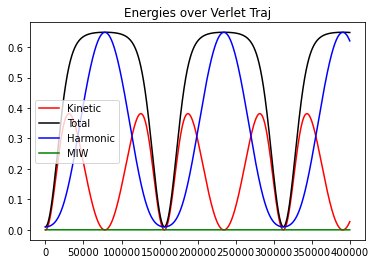

In [12]:
N = 2
spacing = .2
X = Populate1DUniform(N, spacing)
V = np.zeros(X.shape)
M = np.zeros(X.shape)
M += 1836
steps = int(4e5)
params = { "J":1, "D":1, "b":.5, "ktype":"exponential", "M":M, "K":1.0, "xo":0, "dt":1e-3, "steps":steps  }

file = "HarmonicTraj.xyz"
os.system("rm %s" % file)
MIW, Harmonic, Kinetic, Total = VerletDynamics(X, V, params, filename = file)
iterations = np.arange(steps + 1)

plt.figure(9)
plt.plot(iterations, Kinetic, color = 'red', label = 'Kinetic')
plt.plot(iterations, Total, color = 'black', label = 'Total')
plt.plot(iterations, Harmonic, color = 'blue', label = 'Harmonic')
plt.plot(iterations, MIW, color = 'green', label = 'MIW')
plt.title("Energies over Verlet Traj")
plt.legend()
print("MAX MIW potential:MAX Harmonic potential %f" % (max(MIW)/max(Harmonic)))

# Checking energy conservation in simple harmonic system.
- Still not conserved, checking if I have units wrong somewhere or if there is an issue with the integrator.

Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.float64'>
Type of res <class 'numpy.fl

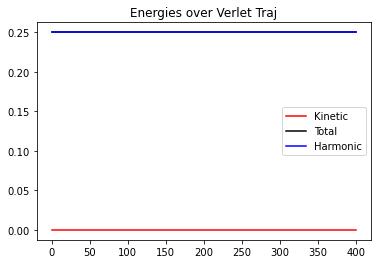

In [47]:
N = 2
spacing = 1
X = Populate1DUniform(N, spacing)
V = np.zeros(X.shape)
M = np.zeros(X.shape)
M += 1836
steps = int(4e2)
params = { "J":1, "D":1, "b":.5, "ktype":"exponential", "M":M, "K":1.0, "xo":0, "dt":1e-3, "steps":steps  }

Kinetic_Energy = np.zeros( steps+1 )
Harmonic_Energy = np.zeros ( Kinetic_Energy.shape )
Total_Energy = np.zeros ( Kinetic_Energy.shape )


Harmonic, Kinetic, Total = VerletDynamics(X, V, params, filename = file, method = 1)
iterations = np.arange(steps + 1)
plt.figure(10)
plt.plot(iterations, Kinetic, color = 'red', label = 'Kinetic')
plt.plot(iterations, Total, color = 'black', label = 'Total')
plt.plot(iterations, Harmonic, color = 'blue', label = 'Harmonic')
plt.title("Energies over Verlet Traj")
plt.legend()

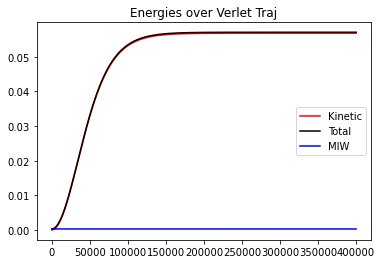

In [175]:
N = 2
spacing = 1
X = Populate1DUniform(N, spacing)
V = np.zeros(X.shape)
M = np.zeros(X.shape)
M += 1836
steps = int(4e5)
params = { "J":1, "D":1, "b":.5, "ktype":"exponential", "M":M, "K":1.0, "xo":0, "dt":1e-3, "steps":steps  }

Kinetic_Energy = np.zeros( steps+1 )
MIW_Energy = np.zeros ( Kinetic_Energy.shape )
Total_Energy = np.zeros ( Kinetic_Energy.shape )


MIW, Kinetic, Total = VerletDynamics(X, V, params, filename = file, method = 2)
iterations = np.arange(steps + 1)
plt.figure(10)
plt.plot(iterations, Kinetic, color = 'red', label = 'Kinetic')
plt.plot(iterations, Total, color = 'black', label = 'Total')
plt.plot(iterations, MIW, color = 'blue', label = 'MIW')
plt.title("Energies over Verlet Traj")
plt.legend()

## MDMin in the harmonic potential.
- Aids in seeing the issue associated with the gaussian kernel, where the particles tend to clump up in optimization.
- Exponential kernel looks good, but I will add something to take X->P(X) for comparison with $|\psi_o|^2$ for H.O. Can use this to quantity

In [22]:
N = 10
spacing = .5
X = Populate1DUniform(N, spacing)

V = np.zeros(X.shape)
M = np.zeros(X.shape)
M += 1

params = {
    "J":1,
    "D":1,
    "b":.5,
    "ktype":"gaussian",
    "M":M,
    "K":1,
    "xo":0,
    "dt":.1,
    "steps":500
}
file = "MDMin.xyz"
os.system("rm %s" % file);
MDMin(X, V, params, filename = file);

Force convergence reached, max force component < 0.000010


### The attempt at recreating Figure 2
- Computes the Log error for N = 2 -> 78 every 2 worlds.
- Should follow the Solid Green Triangles in the Top Left Panel of Fig 2 in Sturniolo
- This is slow because the code is far from optimized, so the same plot is redone in the cell below. 
- - Just did this so that the block directly below could be modified to compare with N=2->N=78 plot.

Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 2
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 4
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 6
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 8
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 10
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 12
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 14
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 16
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 18
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 20
Maximum number of steps reached, max force component not lower than 0.0000

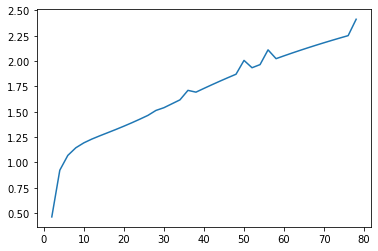

In [22]:
N = 10
spacing = .3
b = .5
D = 1

M = np.zeros(X.shape)
m_p = 1836.0 # Mass of proton in au
M += m_p

eV_A2HaBohr = 0.019446852195816332
K1 = 1*eV_A2HaBohr
steps = 2000
Eo = .0016272651464124717

params = {
    "J":1,
    "D":D,
    "b":b,
    "ktype":"exponential",
    "M":M,
    "K":K1,
    "xo":0,
    "dt":.1,
    "steps":steps
}

LogErr = []
Nworlds = []
Nmax = 80

# Loops through and computes the errors for N = 2 - > N = 80 worlds.
for i in range(1,Nmax):
    if i % 2 == 0:
        N = i
        X = Populate1DUniform(N, spacing)
        V = np.zeros(X.shape)

        M = np.zeros(X.shape)
        m_p = 1836.0 # Mass of proton in au
        M += m_p
        
        params["M"] = M

        Flist, potential = MDMin(X, V, params)
        err = np.log10( abs( potential - (Eo*N) )  / (Eo*N) )
        potential += ((N*D)/(8*M[0][0] * b**2 ))
        print("Finished N =", N)
        Nworlds.append(N)
        LogErr.append(err)



plt.plot(Nworlds, LogErr)
        
# print("Log error for N =", N,  np.log10( abs( potential - (Eo*N) )  / (Eo*N) ) )
# print("Potential %f     |     Eo %f" % (potential, Eo*N) )

In [23]:
plt.plot(Nworlds, LogErr)
plt.title("Harm1")
plt.xlabel("N")
plt.ylabel("log$_{10}[( E - Eo) / Eo]$")

In [42]:
def testreturn():
    return (5.0)

a = testreturn()
print(type(a))

xo = 0
K = 1
X = np.zeros( (2, 1) )
res = Harmonic_Potential(X, xo, K)
print(res)

<class 'float'>
None
